# Neural Style Transfer
(paper) [Neural Style Transfer](https://arxiv.org/abs/1508.06576)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# resize the plt plot to 16, 16
plt.rcParams['figure.figsize'] = (8, 8)

## Gram Matrix

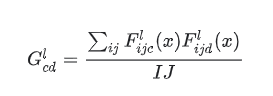

In [3]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return gram_matrix/i_j 

### according to the paper, we have to two choose theses layers as the content and style layers:
* content layers: block4_conv2
* style layers: block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1

In [4]:
def load_model(input_shape=(224, 224, 3)):
    vgg = keras.applications.vgg19.VGG19(include_top=True, weights=None, input_shape=input_shape)
    vgg.load_weights("./models/VGG19/weights.h5")
    vgg.trainable = False
    
    content_layers = ["block4_conv2"]
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

    content_output = vgg.get_layer(content_layers[0]).output
    style_output = [vgg.get_layer(name).output for name in style_layers]
    gram_style_output = [gram_matrix(_output) for _output in style_output]

    model = keras.Model([vgg.input], [content_output, gram_style_output])
    return model

In [5]:
optimizer = keras.optimizers.Adam(lr=0.02, beta_1=0.99, epsilon=1e-1)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
def load_image(path, shape=(224, 224), normalize=True):
    img = cv2.resize(cv2.imread(path), shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, dtype=np.float32)

    if normalize:
        img = img / 255.0

    img = np.expand_dims(img, axis=0)
    
    return img

In [7]:
content_image = load_image("./images/vedant.jpg")
style_image = load_image("./images/abstract-2.jpg")

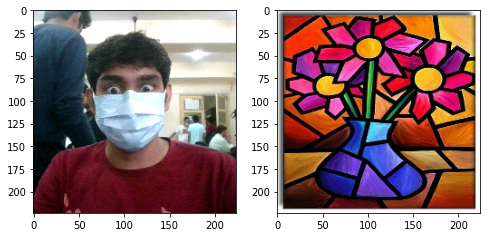

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.show()

### Content Loss:
![content loss](images/style_transfer_content_loss.jpg)

### Style Loss:
![style loss](images/style_transfer_style_loss.jpg)
![style loss](images/style_transfer_style_loss_2.jpg)

### Total Loss:
![total loss](images/style_transfer_total_loss.jpg)<br>

* F -> Content Output
* P -> Content Target
* G -> Style Output
* A -> Style Target

In [9]:
vgg_model = load_model()

In [10]:
def loss_fn(style_outputs, content_outputs, style_target, content_target, content_weight, style_weight):
    content_loss = tf.reduce_mean((content_outputs - content_target)**2)
    style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

In [11]:
content_target = vgg_model([content_image*255])[0]
style_target = vgg_model([style_image*255])[1]

KeyboardInterrupt: 

In [12]:
def train_step(image, epoch, content_target, style_target, content_weight=1e-6, style_weight=1e-2):
    with tf.GradientTape() as tape:
        output = vgg_model([image*255])
        loss = loss_fn(output[1], output[0], style_target, content_target, content_weight, style_weight)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])

    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 == 0:
        tf.print(f"Epoch {epoch} | Loss: {loss}")

In [13]:
content_path = "./images/vedant.jpg"
# style_path = "./images/starry_night_full.jpg"
style_path = "./images/abstract-2.jpg"

In [14]:
def style_image(content_path, style_path, epochs=1000, style_weight=1e-6, content_weight=1e-2):
    content_image = load_image(content_path)
    style_image = load_image(style_path)

    content_target = vgg_model([content_image*255])[0]
    style_target = vgg_model([style_image*255])[1]

    image = tf.image.convert_image_dtype(content_image, tf.float32)
    image = tf.Variable(image)
    
    for i in range(epochs):
        train_step(image, i, content_target, style_target, content_weight, style_weight)
    plt.imshow(image[0])
    plt.show()

Epoch 0 | Loss: 286590944.0
Epoch 100 | Loss: 10063980.0
Epoch 200 | Loss: 4287485.5
Epoch 300 | Loss: 2367518.0
Epoch 400 | Loss: 1519468.875
Epoch 500 | Loss: 1085327.875
Epoch 600 | Loss: 845265.0
Epoch 700 | Loss: 697275.0
Epoch 800 | Loss: 599145.125
Epoch 900 | Loss: 529636.625


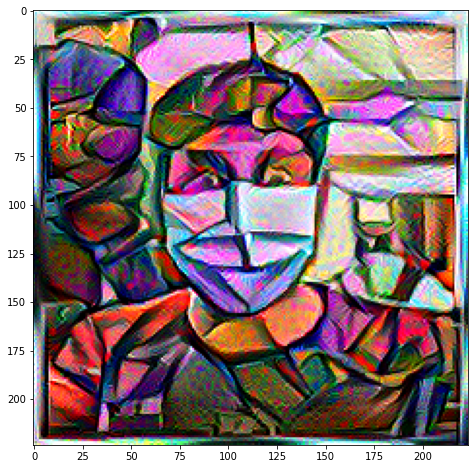

In [15]:
style_image(content_path, style_path, epochs=1000, style_weight=1e-4, content_weight=1e-2)

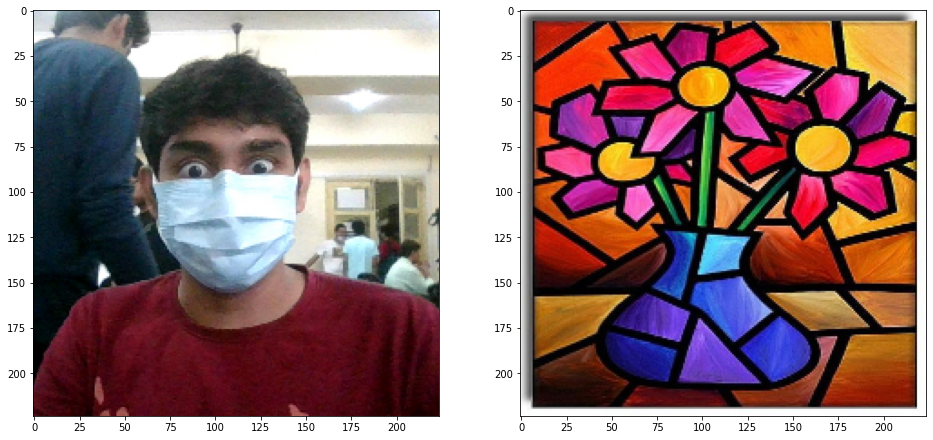

In [18]:
plt.subplot(1, 2, 1)
plt.imshow(load_image(content_path)[0])
plt.subplot(1, 2, 2)
plt.imshow(load_image(style_path)[0])
plt.show()